In [2]:
import os
from dotenv import load_dotenv

In [3]:
_ = load_dotenv()
tavily_api_key = os.getenv("TAVILY_API_KEY")
cohere_api_key = os.getenv("COHERE_API_KEY")
secret_key = os.getenv("LANGFUSE_SECRET_KEY")
public_key = os.getenv("LANGFUSE_PUBLIC_KEY")
langfuse_host = os.getenv("LANGFUSE_HOST")

In [6]:
from langfuse import Langfuse
from langfuse.callback import CallbackHandler
from langfuse.decorators import observe

langfuse = Langfuse(
    secret_key=secret_key,
    public_key=public_key,
    host=langfuse_host
)
langfuse_handler = CallbackHandler(
    secret_key=secret_key,
    public_key=public_key,
    host=langfuse_host
)

In [4]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [8]:
from langchain_cohere.chat_models import ChatCohere

llm = ChatCohere(cohere_api_key=cohere_api_key)

@observe(as_type="generation")
def chatbot(state: State):
    return {
        "messages": [llm.invoke(state["messages"])]
    }

graph_builder.add_node("chatbot", chatbot)

In [9]:
graph_builder.set_entry_point("chatbot")

In [10]:
graph_builder.set_finish_point("chatbot")

In [11]:
graph = graph_builder.compile()

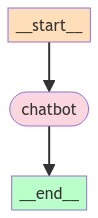

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [14]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: LangGraph is a natural language processing (NLP) tool that provides a visual representation of the relationships between words and concepts in a given piece of text. It uses advanced algorithms to analyze the semantic connections and associations between words, and then generates an interactive graph that illustrates these relationships.

The key features and capabilities of LangGraph include:

1. Word Relationship Visualization: LangGraph creates a graph where nodes represent words or concepts, and edges represent the relationships between them. The proximity and connections between nodes provide insights into how words are related and how they form clusters of related ideas.

2. Semantic Analysis: The tool goes beyond simple keyword matching by considering the context and semantic meaning of words. It takes into account factors such as word co-occurrence, syntactic patterns, and semantic similarity to identify underlying connections between words.

3. Interactive Explorati

In [15]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making ...'},
 {'url': 'https://medium.com/@bhavikjikadara/langgraph-a-comprehensive-guide-for-beginners-ef17d3dd5383',
  'content': 'LangGraph is a library for building stateful, multi-actor applications with LLMs. ... We now need to define a few different nodes in our graph. In langgraph, a node can be either a function or a ...'}]

In [16]:
from typing import Annotated

from langchain_cohere import ChatCohere
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatCohere(cohere_api_key=cohere_api_key)
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [17]:
import json

from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [18]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

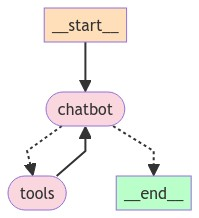

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [20]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: I will search for 'langgraph' and write an answer based on the results.
Assistant: [{"url": "https://github.com/langchain-ai/langgraph", "content": "LangGraph is a library for building stateful, multi-actor applications with LLMs using regular python functions or JS. Learn how to create graphs with nodes, edges, state, tools, and conditional edges for agentic behaviors."}, {"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Compared to other LLM frameworks, it offers these core benefits: cycles, controllability, and persistence. LangGraph allows you to define flows that involve cycles, essential for most agentic architectures ..."}]
Assistant: LangGraph is a library for building stateful, multi-actor applications with LLMs. It can be used to create agent and multi-agent workflows. LangGraph offers core benefits such as cycles, control